So in my quest to recover some experience from my uni days, I'm building up to a custom implementation of SLAM from first principles. First thing's first, everybody's favorite control system, the pendulum!

We know the model of the pendulum to be:
$$\frac{d^2\theta}{dt^2}+\frac{g}{\ell}\sin{\theta} = 0$$

In [1]:
# %matplotlib ipympl
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

g = 9.81
l = 1.0
theta_0 = np.zeros(2)

In [2]:
def f(x, t0, params):
    g, l = params['g'], params['l']
    theta, dtheta = x[0], x[1]
    ddtheta = - (g / l) * np.sin(theta)
    return np.array([dtheta, ddtheta])

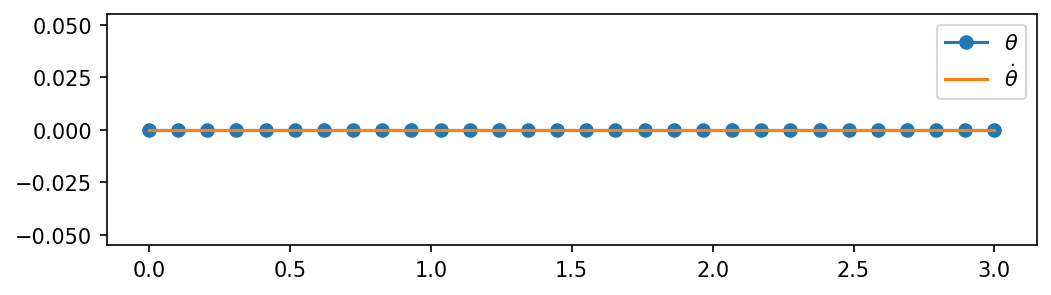

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
t = np.linspace(0., 3., 30)
theta = spi.odeint(f, theta_0, t, args=({"g": g, "l": l},))
ax.plot(t, theta[:, 0], 'o-', label='$\\theta$')
ax.plot(t, theta[:, 1], '-', label='$\\dot{\\theta}$')
ax.legend()

Well, that's pretty boring. Let's try some more exciting initial conditions, such as:
$$\begin{bmatrix}
\theta \\ \dot{\theta}
\end{bmatrix}
= 
\begin{bmatrix}
\pi/2 \\ 0
\end{bmatrix}
$$

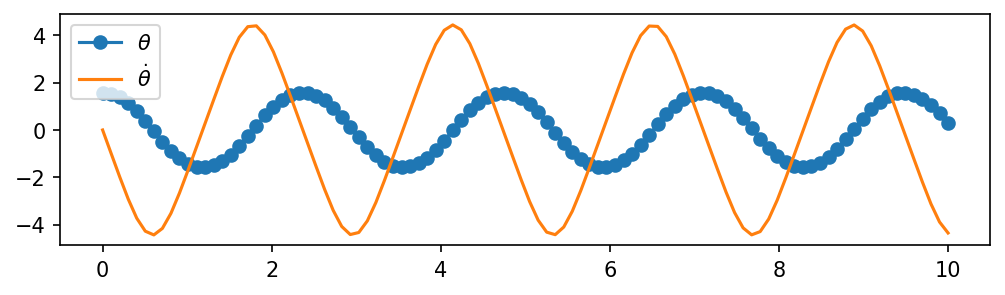

In [4]:
theta_0 = np.array([np.pi/2, 0])
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
t = np.linspace(0., 10., 100)
theta = spi.odeint(f, theta_0, t, args=({"g": g, "l": l},))
ax.plot(t, theta[:, 0], 'o-', label='$\\theta$')
ax.plot(t, theta[:, 1], '-', label='$\\dot{\\theta}$')
ax.legend()

Much better! Now, we can use some movie magic (ahem LLMs) and try to create an animation based on this. I got Gemini to generate the following code:

In [5]:
from matplotlib.animation import FuncAnimation

def animate_pendulum(t, states, params):
    """
    Animates a simple pendulum.
    
    Parameters:
    t      : array of time steps
    states : array of state vectors [[theta1, dtheta1], [theta2, dtheta2], ...]
    l      : length of the pendulum arm
    """
    # 1. Convert angles to Cartesian coordinates
    theta = states[:, 0]
    l = params['l']
    x = l * np.sin(theta)
    y = -l * np.cos(theta)  # Negative because it hangs down from (0,0)

    # 2. Set up the figure and axis
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-l * 1.2, l * 1.2)
    ax.set_ylim(-l * 1.2, l * 1.2)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--')
    
    # 3. Create the visual elements
    # The rod (line), the bob (large circle marker), and the trace (faded line)
    line, = ax.plot([], [], 'o-', lw=2, color='#2c3e50', markersize=10, markerfacecolor='#e74c3c')
    trace, = ax.plot([], [], '-', lw=1, color='#e74c3c', alpha=0.3)
    
    # 4. Initialization function for the animation
    def init():
        line.set_data([], [])
        trace.set_data([], [])
        return line, trace

    # 5. Animation update function
    def update(i):
        # Update the rod and bob position
        this_x = [0, x[i]]
        this_y = [0, y[i]]
        line.set_data(this_x, this_y)
        
        # Update the trace (showing previous positions)
        trace.set_data(x[:i], y[:i])
        return line, trace

    # 6. Create the animation
    # interval is the delay between frames in milliseconds
    # blit=True makes the animation run faster by only redrawing changed parts
    ani = FuncAnimation(fig, update, frames=len(t), init_func=init, 
                        blit=True, interval=(t[1]-t[0])*1000)

    plt.title("Pendulum Simulation")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    
    return ani

We can now simulate a quick animation of the pendulum:

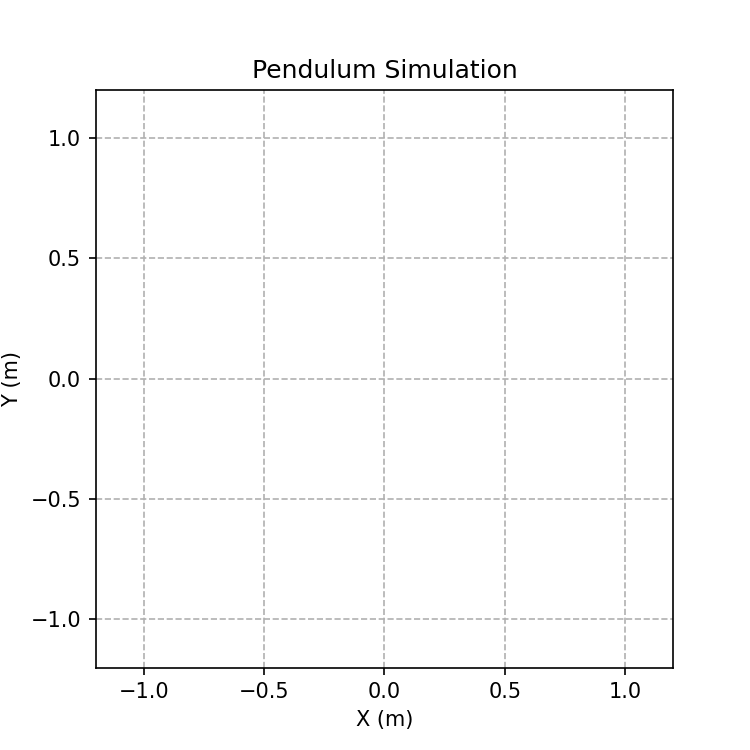

In [6]:
%matplotlib widget

theta_0 = np.array([np.pi/2 * 1.1, 0])
t = np.linspace(0., 10., 100)
theta = spi.odeint(f, theta_0, t, args=({"g": g, "l": l},))

animation = animate_pendulum(t, theta, {"l": l})
plt.show()

I now want to check the effect of initial conditions on the evolution of the system at the different equilibrium points. Intuitively we can locate these points at the downwards and upwards positions, but we can also quickly determine these points by setting the derivative to zero (I will now use $x$ to refer to the state vector $(\theta, \dot{\theta})$):

$$ \dot{x} = 0 \rightarrow \begin{bmatrix}\dot{\theta} \\ \ddot{\theta}  \end{bmatrix} = \begin{bmatrix}0\\ 0  \end{bmatrix}  = \begin{bmatrix}\dot{\theta} \\  -\frac{g}{\ell}\sin{\theta} \end{bmatrix}$$

From the first equation, the angular velocity must be 0. From the second equation, we obtain the following relation:
$$ \sin{\theta} = 0 \rightarrow \; \theta_{eq} = n\pi,\; n = 0, 1, 2, ...$$

We therefore know we'll find these equilibrium points at any multiple of $\pi$. In this case, we only care for what's in the interval $[0,2\pi]$, so we study the first two equilibrium points, $0$ and $\pi$. Using the Jacobian we can determine the type of stability of the equilibrium points. If:
- All the eigenvalues of the Jacobian have negative real parts $\mathrm{Re}(\lambda_i) < 0$, the system is **asymptotically stable**.
- Any of the eigenvalues of the Jacobian have a positive real part, the system is **unstable**.

For our purposes, it is pretty evident that the equilibrium point $[0, 0]$ is stable, whereas the equilibrium point $[\pi, 0]$ is unstable. We can try plotting the results of starting the system in this unstable equilibrium point, as well as slightly shifted away from it (around 0.11 radians or 0.6 degrees)

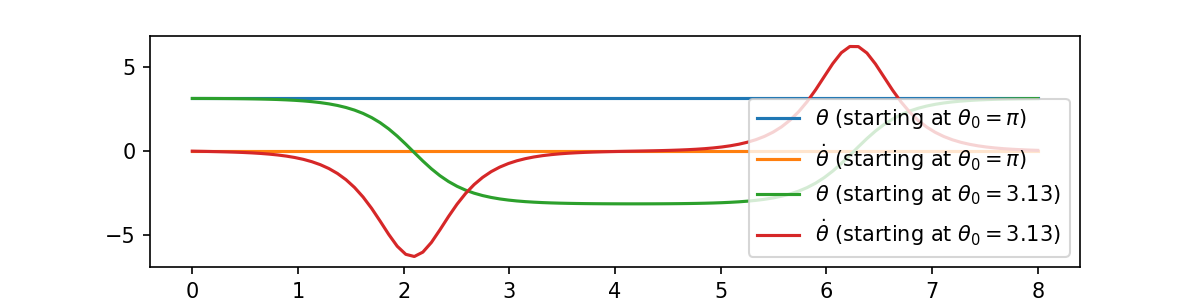

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
t = np.linspace(0., 8., 100)
# Unstable point (hope that pi is represented well enough with floating point)
theta_0 = np.array([np.pi, 0])
theta_unstable = spi.odeint(f, theta_0, t, args=({"g": g, "l": l},))
# Unstable point + eps
theta_0 = np.array([3.13, 0])
theta_unstable_plus_eps = spi.odeint(f, theta_0, t, args=({"g": g, "l": l},))
# Plot
ax.plot(t, theta_unstable[:, 0], '-', label='$\\theta$ (starting at $\\theta_0 = \\pi$)')
ax.plot(t, theta_unstable[:, 1], '-', label='$\\dot{\\theta}$ (starting at $\\theta_0 = \\pi$)')
ax.plot(t, theta_unstable_plus_eps[:, 0], '-', label='$\\theta$ (starting at $\\theta_0 = 3.13$)')
ax.plot(t, theta_unstable_plus_eps[:, 1], '-', label='$\\dot{\\theta}$ (starting at $\\theta_0 = 3.13$)')
ax.legend()

The last plot shows pretty evidently the effects of the unstable equilibrium point. By starting just 0.6 degrees away from the equilibrium point, we've managed to make the pendulum start swinging as it typically does. This wraps it up for today! In the next post, I'll talk about linearizing this system and we can try controlling it.